# Start of actual analysis

Previous Paper: https://pubmed.ncbi.nlm.nih.gov/30334800/ 

used similar dataset, LSTM + 1d-AX + softmax

1d-AX: kinda like windowed mean in A2



Hybrid NN in time domain: https://www.biorxiv.org/content/10.1101/2020.09.20.305300v1.full

In [55]:
# import packages
import biosig
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.signal import butter, sosfiltfilt, sosfreqz 


import scipy.io
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Conv1D
from keras.optimizers import SGD, Nadam, Adam, RMSprop
from keras.metrics import Precision, Recall

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix, classification_report

import mne
from mne.decoding import CSP
from mne import create_info

from tqdm import tqdm

In [46]:
# Define variables here
#Xuanyu
data_path = './BCICIV_2b_gdf/'#the folder where all raw data files live

#Can
#data_path = '/Users/canliu/COGS 189/Project'

train_portion = 0.7 #the portion of training data among all the raw data files

# from the data description document
event_start = 4 #the start time point (sec) of imagery for each trial
event_end = 7 #the end time point (sec) of imagery for each trial
bsl_start = 0 #the start time point (sec) of baseline for each trial
bsl_end = 2 #the end time point (sec) of baseline for each trial

files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
train_files = [f for f in files if f[-5]=='T']
# for testing purposes only
#train_files = files[:5]

## Define functions

In [27]:
def time_ind_conversion(sr, t):
    """
    Convert time in second to the index in the signal array
    """
    return int(np.round(sr*t))


# from A1
def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y

def populate_filt_data(files, event_start, event_end, bsl_start, bsl_end, lowcut=7, highcut=30):
    """
    populate and pre-process data for training the model
    
    "It is noted in the literature that while performing any motor imagery tasks, 
    two major frequency band of EEG spectrum i.e mu (7-12 Hz) as well as beta (12-30 Hz) 
    bands are actively involved."
    
    input:
        files: list of file paths to the raw data files
        event_start: the start time point (sec) of imagery for each trial
        event_end: the end time point (sec) of imagery for each trial
        bsl_start: the start time point (sec) of baseline for each trial
        bsl_end: the end time point (sec) of baseline for each trial
        lowcut: lower end of the bandpass filter, default=7Hz
        highcut: higher end of the bandpass filter, default=30Hz
        
    output:
        data: list of eeg signal segments for each imagery 
        label: list of labels for each segment
    
    """
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)]
        all_data = biosig.data(i).T
        
        for j in mi_events.index:
            t_start = time_ind_conversion(sr, events.POS[j-1]+event_start)
            t_end = time_ind_conversion(sr, events.POS[j-1]+event_end)
            #only use the EEG channels to prevent the model learning EOG patterns
            seg = all_data[:3, t_start:t_end]
            #calculate baseline and trial mean
            t_bsl_start = time_ind_conversion(sr, events.POS[j-1]+bsl_start)
            t_bsl_end = time_ind_conversion(sr, events.POS[j-1]+bsl_end)
            bsl_sig = all_data[:3, t_bsl_start:t_bsl_end]
            bsl = np.nanmean(bsl_sig, 1)
            trial_mean = np.nanmean(seg, 1)
            #preprocess the data by subtract baseline and the trial mean
            seg_after = butter_bandpass_filter((seg.T - bsl - trial_mean).T, lowcut=lowcut, highcut=highcut, fs=sr)
            if np.isnan(seg_after).sum()==0:
                data.append(seg_after)
                labels.append(mi_events.Description[j])
    return data, labels

def reshape_data(data, label):
    """
    reshape the data to the shape: n_samples * time * channels
    binarize the labels for the model
    """
    x = np.dstack(data)
    x = x.reshape(x.shape[2], x.shape[1], x.shape[0])
    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(label)
    return x, y

def create_model(filters=256, pool_size=4, units=64, dropout=0.1, optim='adam'):
    model=Sequential()
    model.add(Conv1D(filters=filters, kernel_size=5, activation = 'relu', input_shape = (750, 3)))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model



## Build the model

### high pass + ICA (remove EOG) + CSP (augmentation)+ 1DConv(feature extraction) + LSTM (sequential learning)

In [ ]:
# This doesn't work... Why?


# train_data, train_label = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
# data, label = reshape_data(train_data, train_label)
# ica = FastICA(n_components=3)
# all_c3 = data[:,:,0]
# components = ica.fit_transform(all_c3)


In [35]:
# Load data after band-pass filter
train_data, train_label = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)

# TODO: Skip ICA for now because it didn't work

# CSP transformation
csp = CSP(rank={'eeg':3}, transform_into = 'csp_space')
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y)).reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y)).reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2])

# plot top CSP filters here

Computing rank from data with rank={'eeg': 3}
    Using tolerance 1.2 (2.2e-16 eps * 3 dim * 1.8e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank={'eeg': 3, 'mag': 3}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.


In [63]:
# plot top filters, Doesn't work: No digitization points found.
# info = create_info(ch_names=['C3', 'Cz', 'C4'], sfreq=250.0, ch_types = 'eeg')
# csp.plot_patterns(info=info, ch_type='eeg', sphere=0.095)

In [41]:
# build model here
model = create_model()
model.fit(x_new, train_y, epochs=20, batch_size=50)
model.evaluate(x_new_test, test_y)

Epoch 1/20
40/40 [==============================] - 22s 504ms/step - loss: 0.6990 - accuracy: 0.4851
Epoch 2/20
40/40 [==============================] - 18s 454ms/step - loss: 0.6917 - accuracy: 0.5318
Epoch 3/20
40/40 [==============================] - 19s 466ms/step - loss: 0.6878 - accuracy: 0.5301
Epoch 4/20
40/40 [==============================] - 18s 455ms/step - loss: 0.6867 - accuracy: 0.5574
Epoch 5/20
40/40 [==============================] - 18s 454ms/step - loss: 0.6832 - accuracy: 0.5417
Epoch 6/20
40/40 [==============================] - 22s 543ms/step - loss: 0.6829 - accuracy: 0.5453
Epoch 7/20
40/40 [==============================] - 22s 555ms/step - loss: 0.6737 - accuracy: 0.5613
Epoch 8/20
40/40 [==============================] - 19s 472ms/step - loss: 0.6661 - accuracy: 0.5871
Epoch 9/20
40/40 [==============================] - 19s 482ms/step - loss: 0.6620 - accuracy: 0.5882
Epoch 10/20
40/40 [==============================] - 19s 468ms/step - loss: 0.6437 - accura

[0.8645426630973816, 0.5040816068649292]

[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

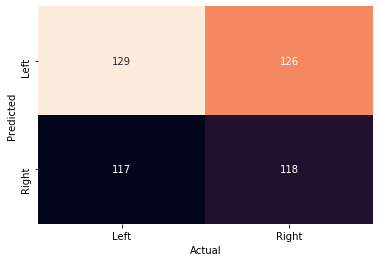

In [42]:
y_pred = model.predict_classes(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

In [44]:
print(classification_report(test_y, np.rint(y_pred)))

              precision    recall  f1-score   support

           0       0.52      0.51      0.51       255
           1       0.48      0.50      0.49       235

    accuracy                           0.50       490
   macro avg       0.50      0.50      0.50       490
weighted avg       0.50      0.50      0.50       490



### Train on each individual

In [58]:
def training_pipeline(train_data, train_label, verbose=1):
    data, label = reshape_data(train_data, train_label)
    train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.3, random_state=42)

    # TODO: Skip ICA for now because it didn't work

    # CSP transformation
    csp = CSP(rank={'eeg':3}, transform_into = 'csp_space')
    x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                              np.squeeze(train_y)).reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                                   np.squeeze(test_y)).reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2])
    model = create_model()
    model.fit(x_new, train_y, epochs=10, batch_size=20, verbose=verbose)
    y_pred = model.predict_classes(x_new_test)
    eval_result = classification_report(test_y, np.rint(y_pred), output_dict=True)
    return eval_result


In [59]:
results = []
mne.set_log_level('warning')
for i in tqdm(range(len(train_files))):
    print('Training sample #%d'%i)
    train_data, train_label = populate_filt_data([train_files[i]], event_start, event_end, bsl_start, bsl_end)
    eval_result = training_pipeline(train_data, train_label, verbose=0)
    results.append(eval_result)



  0%|          | 0/27 [00:00<?, ?it/s]

Training sample #0


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


  4%|▎         | 1/27 [00:21<09:29, 21.92s/it]

Training sample #1




  7%|▋         | 2/27 [00:38<08:28, 20.35s/it]

Training sample #2




 11%|█         | 3/27 [00:58<08:07, 20.30s/it]

Training sample #3




 15%|█▍        | 4/27 [01:16<07:29, 19.56s/it]

Training sample #4




 19%|█▊        | 5/27 [01:38<07:27, 20.32s/it]

Training sample #5




 22%|██▏       | 6/27 [01:57<06:55, 19.80s/it]

Training sample #6




 26%|██▌       | 7/27 [02:13<06:12, 18.64s/it]

Training sample #7




 30%|██▉       | 8/27 [02:31<05:50, 18.43s/it]

Training sample #8




 33%|███▎      | 9/27 [02:47<05:20, 17.79s/it]

Training sample #9




 37%|███▋      | 10/27 [03:08<05:20, 18.83s/it]

Training sample #10




 41%|████      | 11/27 [03:28<05:04, 19.00s/it]

Training sample #11




 44%|████▍     | 12/27 [03:45<04:39, 18.60s/it]

Training sample #12




 48%|████▊     | 13/27 [04:01<04:07, 17.68s/it]

Training sample #13




 52%|█████▏    | 14/27 [04:20<03:54, 18.00s/it]

Training sample #14




 56%|█████▌    | 15/27 [04:35<03:25, 17.15s/it]

Training sample #15




 59%|█████▉    | 16/27 [04:51<03:05, 16.87s/it]

Training sample #16




 63%|██████▎   | 17/27 [05:13<03:05, 18.55s/it]

Training sample #17




 67%|██████▋   | 18/27 [05:29<02:39, 17.76s/it]

Training sample #18




 70%|███████   | 19/27 [05:45<02:17, 17.14s/it]

Training sample #19




 74%|███████▍  | 20/27 [06:04<02:04, 17.73s/it]

Training sample #20




 78%|███████▊  | 21/27 [06:23<01:47, 17.96s/it]

Training sample #21




 81%|████████▏ | 22/27 [06:38<01:25, 17.17s/it]

Training sample #22




 85%|████████▌ | 23/27 [06:53<01:06, 16.62s/it]

Training sample #23




 89%|████████▉ | 24/27 [07:12<00:52, 17.36s/it]

Training sample #24




 93%|█████████▎| 25/27 [07:28<00:33, 16.85s/it]

Training sample #25




 96%|█████████▋| 26/27 [07:44<00:16, 16.45s/it]

Training sample #26




100%|██████████| 27/27 [07:59<00:00, 17.76s/it]


In [60]:
results

[{'0': {'precision': 0.5384615384615384,
   'recall': 0.6666666666666666,
   'f1-score': 0.5957446808510638,
   'support': 21},
  '1': {'precision': 0.6818181818181818,
   'recall': 0.5555555555555556,
   'f1-score': 0.6122448979591836,
   'support': 27},
  'accuracy': 0.6041666666666666,
  'macro avg': {'precision': 0.6101398601398601,
   'recall': 0.6111111111111112,
   'f1-score': 0.6039947894051236,
   'support': 48},
  'weighted avg': {'precision': 0.6190996503496503,
   'recall': 0.6041666666666666,
   'f1-score': 0.6050260529743812,
   'support': 48}},
 {'0': {'precision': 0.55,
   'recall': 0.6470588235294118,
   'f1-score': 0.5945945945945946,
   'support': 17},
  '1': {'precision': 0.625,
   'recall': 0.5263157894736842,
   'f1-score': 0.5714285714285714,
   'support': 19},
  'accuracy': 0.5833333333333334,
  'macro avg': {'precision': 0.5875,
   'recall': 0.586687306501548,
   'f1-score': 0.583011583011583,
   'support': 36},
  'weighted avg': {'precision': 0.589583333333333

In [68]:
all_avg_precision = [x['weighted avg']['precision'] for x in results]
all_avg_recall = [x['weighted avg']['recall'] for x in results]
all_accuracy = [x['accuracy']for x in results]

(array([4., 2., 3., 4., 5., 2., 2., 2., 2., 1.]),
 array([0.38888889, 0.41388889, 0.43888889, 0.46388889, 0.48888889,
        0.51388889, 0.53888889, 0.56388889, 0.58888889, 0.61388889,
        0.63888889]),
 <a list of 10 Patch objects>)

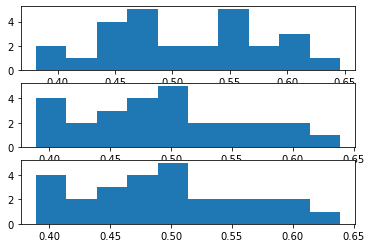

In [66]:
plt.subplot(3, 1, 1)
plt.hist(all_avg_precision)
plt.subplot(3, 1, 2)
plt.hist(all_avg_recall)
plt.subplot(3, 1, 3)
plt.hist(all_accuracy)

In [70]:
print('mean precision = %f'%np.mean(all_avg_precision))
print('mean recall = %f'%np.mean(all_avg_recall))
print('mean accuracy = %f'%np.mean(all_accuracy))

mean precision = 0.511142
mean recall = 0.493952
mean accuracy = 0.493952


### One specific example

Epoch 1/10
6/6 [==============================] - 3s 270ms/step - loss: 0.6978 - accuracy: 0.5181
Epoch 2/10
6/6 [==============================] - 2s 282ms/step - loss: 0.6775 - accuracy: 0.5415
Epoch 3/10
6/6 [==============================] - 2s 295ms/step - loss: 0.6547 - accuracy: 0.6327
Epoch 4/10
6/6 [==============================] - 2s 278ms/step - loss: 0.6427 - accuracy: 0.6109
Epoch 5/10
6/6 [==============================] - 2s 277ms/step - loss: 0.6375 - accuracy: 0.6261
Epoch 6/10
6/6 [==============================] - 2s 322ms/step - loss: 0.6228 - accuracy: 0.6311
Epoch 7/10
6/6 [==============================] - 2s 342ms/step - loss: 0.5707 - accuracy: 0.7022
Epoch 8/10
6/6 [==============================] - 2s 310ms/step - loss: 0.5694 - accuracy: 0.7209
Epoch 9/10
6/6 [==============================] - 2s 311ms/step - loss: 0.5723 - accuracy: 0.6966
Epoch 10/10
2/2 [==============================] - 1s 92ms/step - loss: 0.6903 - accuracy: 0.6458


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

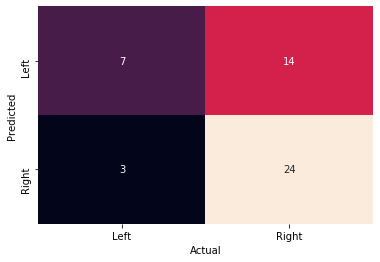

In [71]:
# Load data after band-pass filter
train_data, train_label = populate_filt_data([train_files[0]], event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.3, random_state=42)

# TODO: Skip ICA for now because it didn't work

# CSP transformation
csp = CSP(rank={'eeg':3}, transform_into = 'csp_space')
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y)).reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y)).reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2])
model = create_model()
model.fit(x_new, train_y, epochs=10, batch_size=20)
eval_result = model.evaluate(x_new_test, test_y, return_dict=True)

y_pred = model.predict_classes(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

In [72]:
classification_report(test_y, np.rint(y_pred), output_dict=True)

{'0': {'precision': 0.7,
  'recall': 0.3333333333333333,
  'f1-score': 0.45161290322580644,
  'support': 21},
 '1': {'precision': 0.631578947368421,
  'recall': 0.8888888888888888,
  'f1-score': 0.7384615384615385,
  'support': 27},
 'accuracy': 0.6458333333333334,
 'macro avg': {'precision': 0.6657894736842105,
  'recall': 0.611111111111111,
  'f1-score': 0.5950372208436725,
  'support': 48},
 'weighted avg': {'precision': 0.6615131578947367,
  'recall': 0.6458333333333334,
  'f1-score': 0.6129652605459057,
  'support': 48}}

## CSP-LDA baseline model

In [75]:
train_data, train_label = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)
csp = CSP(n_components=4, rank={'eeg':3})
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y))
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y))
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(x_new, train_y)
lda.score(x_new_test, test_y)

/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.47203274215552526

[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

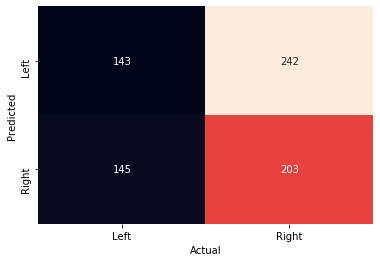

In [77]:
y_pred = lda.predict(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

In [79]:
print(classification_report(test_y, np.rint(y_pred)))

              precision    recall  f1-score   support

           0       0.50      0.37      0.42       385
           1       0.46      0.58      0.51       348

    accuracy                           0.47       733
   macro avg       0.48      0.48      0.47       733
weighted avg       0.48      0.47      0.47       733



### On each individual

In [86]:
def csp_lda_pipeline(train_data, train_label):
    data, label = reshape_data(train_data, train_label)
    train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.3, random_state=42)

    csp = CSP(n_components=4, rank={'eeg':3})
    x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                              np.squeeze(train_y))
    x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                                   np.squeeze(test_y))
    lda = LinearDiscriminantAnalysis(solver = 'lsqr')
    lda.fit(x_new, train_y)
    print(lda.score(x_new_test, test_y))

    y_pred = lda.predict(x_new_test)
    eval_result = classification_report(test_y, np.rint(y_pred), output_dict=True)
    return eval_result

In [87]:
results = []
mne.set_log_level('warning')
for i in tqdm(range(len(train_files))):
    print('Training sample #%d'%i)
    train_data, train_label = populate_filt_data([train_files[i]], event_start, event_end, bsl_start, bsl_end)
    eval_result = csp_lda_pipeline(train_data, train_label)
    results.append(eval_result)
all_avg_precision = [x['weighted avg']['precision'] for x in results]
all_avg_recall = [x['weighted avg']['recall'] for x in results]
all_accuracy = [x['accuracy']for x in results]



  0%|          | 0/27 [00:00<?, ?it/s]

Training sample #0


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  4%|▎         | 1/27 [00:00<00:10,  2.55it/s]

0.4166666666666667
Training sample #1


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  7%|▋         | 2/27 [00:00<00:09,  2.62it/s]

0.5277777777777778
Training sample #2


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 11%|█         | 3/27 [00:01<00:09,  2.46it/s]

0.4375
Training sample #3


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 15%|█▍        | 4/27 [00:01<00:08,  2.63it/s]

0.4444444444444444
Training sample #4


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 19%|█▊        | 5/27 [00:01<00:08,  2.57it/s]

0.6041666666666666
Training sample #5


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 22%|██▏       | 6/27 [00:02<00:07,  2.73it/s]

0.4166666666666667
Training sample #6


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 26%|██▌       | 7/27 [00:02<00:07,  2.81it/s]

0.3333333333333333
Training sample #7


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 30%|██▉       | 8/27 [00:02<00:06,  2.88it/s]

0.4444444444444444
Training sample #8


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 33%|███▎      | 9/27 [00:03<00:05,  3.03it/s]

0.6388888888888888
Training sample #9


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 37%|███▋      | 10/27 [00:03<00:05,  2.87it/s]

0.3541666666666667
Training sample #10


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 41%|████      | 11/27 [00:03<00:05,  2.85it/s]

0.5111111111111111
Training sample #11


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 44%|████▍     | 12/27 [00:04<00:05,  2.85it/s]

0.42857142857142855
Training sample #12


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 48%|████▊     | 13/27 [00:04<00:05,  2.77it/s]

0.5833333333333334
Training sample #13


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 52%|█████▏    | 14/27 [00:05<00:04,  2.69it/s]

0.5833333333333334
Training sample #14


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 56%|█████▌    | 15/27 [00:05<00:04,  2.78it/s]

0.3611111111111111
Training sample #15


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 59%|█████▉    | 16/27 [00:05<00:03,  2.82it/s]

0.5555555555555556
Training sample #16


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 63%|██████▎   | 17/27 [00:06<00:03,  2.76it/s]

0.4791666666666667
Training sample #17


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 67%|██████▋   | 18/27 [00:06<00:03,  2.89it/s]

0.3611111111111111
Training sample #18


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 70%|███████   | 19/27 [00:06<00:02,  2.97it/s]

0.4166666666666667
Training sample #19


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 74%|███████▍  | 20/27 [00:07<00:02,  2.92it/s]

0.625
Training sample #20


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 78%|███████▊  | 21/27 [00:07<00:02,  2.75it/s]

0.625
Training sample #21


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 81%|████████▏ | 22/27 [00:07<00:01,  2.86it/s]

0.3333333333333333
Training sample #22


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 85%|████████▌ | 23/27 [00:08<00:01,  2.92it/s]

0.5
Training sample #23


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 89%|████████▉ | 24/27 [00:08<00:01,  2.85it/s]

0.4375
Training sample #24


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 93%|█████████▎| 25/27 [00:08<00:00,  2.82it/s]

0.38095238095238093
Training sample #25


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 96%|█████████▋| 26/27 [00:09<00:00,  2.93it/s]

0.4722222222222222
Training sample #26


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|██████████| 27/27 [00:09<00:00,  2.82it/s]

0.4722222222222222


(array([5., 1., 3., 5., 3., 2., 1., 1., 3., 3.]),
 array([0.33333333, 0.36388889, 0.39444444, 0.425     , 0.45555556,
        0.48611111, 0.51666667, 0.54722222, 0.57777778, 0.60833333,
        0.63888889]),
 <a list of 10 Patch objects>)

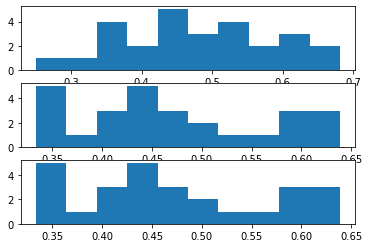

In [88]:
plt.subplot(3, 1, 1)
plt.hist(all_avg_precision)
plt.subplot(3, 1, 2)
plt.hist(all_avg_recall)
plt.subplot(3, 1, 3)
plt.hist(all_accuracy)

In [89]:
print('mean precision = %f'%np.mean(all_avg_precision))
print('mean recall = %f'%np.mean(all_avg_recall))
print('mean accuracy = %f'%np.mean(all_accuracy))

mean precision = 0.480221
mean recall = 0.472009
mean accuracy = 0.472009


0.4166666666666667


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

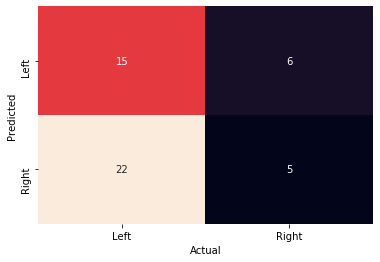

In [81]:
train_data, train_label = populate_filt_data([train_files[0]], event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.3, random_state=42)

csp = CSP(n_components=4, rank={'eeg':3})
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y))
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y))
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(x_new, train_y)
print(lda.score(x_new_test, test_y))

y_pred = lda.predict(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

# Questions for check point 1

1. Remove EOG artifact: Needed? How?
    
2. Another tangent: feasible to include EOG information in the classification? Individual variation too high?
    
3. CSP? Restricted by the number of channels?
    
4. Difference not distinct between averaged signals
    
5. Amplitude much smaller after averaging, also noisier
    
6. preprocesing data: does order matter (DC offset -> filtfilt -> baseline correct); what else needed?


compute C3-C4, C4-C3, or diff with Cz, then bandpass 7-30Hz
take the log of the power (normally distributed)

diff more distinct in freq space

EOG artifact:

ICA (http://www.cogsci.ucsd.edu/academicPubs/igorodni/eog-filtering.pdf)

subtract EOG from EEG? **find code**

## Questions for check point 2

1. accuracy not good... problem with approach?
2. data augmentation? 
    
    "deep convolutional generative adversarial network (DCGAN) provided better augmentation performance than traditional DA methods: geometric transformation (GT), autoencoder (AE), and variational autoencoder (VAE)"
    
    Is CSP a kind of data augmentation? no, but generate better features
    
    Worth trying? time domain: high pass + ICA (remove EOG) + CSP (augmentation)+ 1DConv + max pooling (feature extraction) + LSTM (sequential learning)
    
    try CSP with top 3 filters

Try on 64 channel set

Run model only on EOG to make sure the model is not using eye moving data

Try train on individual data